In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T
from datasets import load_dataset
from jpeg.DiffJPEG import DiffJPEG
from PIL import Image
from transformers import ConvNextForImageClassification, ConvNextImageProcessor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [3]:
def pytorch_jpeg_compress(img_tensor):
    quality = np.random.randint(50, 90)
    img = Image.fromarray(
        (
            np.clip(img_tensor.cpu().numpy().swapaxes(0, 1).swapaxes(1, 2), 0, 1) * 255
        ).astype(np.uint8)
    )

    with io.BytesIO() as f:
        img.save(f, "JPEG", quality=quality)
        img = Image.open(io.BytesIO(f.getvalue()))

    out_tensor = torch.tensor(
        np.array(img).swapaxes(2, 1).swapaxes(1, 0) / 255,
        device=img_tensor.device,
        dtype=torch.float32,
    )
    return out_tensor

def img_to_tensor(img):
    img = T.ToTensor()(img)
    return img.unsqueeze(0)

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize(img):
    return T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])(img)

def tensor_to_img(img_tensor):
    if img_tensor.shape[0] == 1:
        img_tensor = img_tensor.squeeze(0)
    img = img_tensor.detach().cpu().numpy().swapaxes(0, 1).swapaxes(1, 2)
    img = np.clip(img, 0, 1)
    return Image.fromarray((img * 255).astype(np.uint8))

def differentiable_jpeg(img_tensor, quality, device=device):
    _, _, h, w = img_tensor.shape
    return DiffJPEG(quality=quality, height=h, width=w, device=device)(img_tensor)

random_crop = T.RandomResizedCrop(384, antialias=True)

In [4]:
processor = ConvNextImageProcessor.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache")
HFmodel = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache").eval()
model = next(HFmodel.modules()).to(device)

dataset = load_dataset("huggingface/cats-image", cache_dir="./cache", trust_remote_code=True)
img_original = np.array(dataset["test"]["image"][0])
img_original_tensor = img_to_tensor(Image.fromarray(img_original)).to(device)

/home/outwrest/anaconda3/envs/txtai/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
n_iterations = 100
target_output = torch.tensor([383], dtype=torch.long, device=device) # do the same for 383 - 388
eps = 8. / 255. # perturbation size, set lower than needed for rounding errors
bs = 8 # batch size - not really needed, but stabilizes training and improves convergence & consistency of adversarial examples

x = img_original_tensor.clone()
x.requires_grad = True

optimizer = torch.optim.Adam([x], lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()

def forward(x):
    x = differentiable_jpeg(x, random.randint(50, 90))
    x = normalize(x)
    x = random_crop(x)
    x = model(x).logits
    return x

for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    logits = forward(torch.cat([x] * bs, dim=0)) # helps as each forward pass is different, helps stabilize training
    loss = loss_func(logits, torch.cat([target_output] * bs, dim=0))
    loss.backward()

    optimizer.step()

    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if iteration % (n_iterations // 10) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(np.array(current_img).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        prediction_idx = torch.argmax(logits).item()
        prediction_prob = torch.nn.functional.softmax(logits, dim=1)[0, prediction_idx].item() * 100

        print(
            f"Iter: {iteration: <4} | Loss: {loss.item(): .4f} | Pred: {prediction_idx} ({prediction_prob:.2f}%) | "
            f"min/mean/max diff: {min_d:.2f}/{mean_d:.2f}/{max_d:.2f}"
        )

Iter: 0    | Loss:  8.5492 | Pred: 281 (54.20%) | min/mean/max diff: 0.00/1.44/3.00
Iter: 10   | Loss:  0.2835 | Pred: 383 (75.32%) | min/mean/max diff: 0.00/5.35/9.00
Iter: 20   | Loss:  0.1862 | Pred: 383 (83.01%) | min/mean/max diff: 0.00/6.11/9.00
Iter: 30   | Loss:  0.1670 | Pred: 383 (84.62%) | min/mean/max diff: 0.00/6.17/9.00
Iter: 40   | Loss:  0.4805 | Pred: 383 (61.85%) | min/mean/max diff: 0.00/6.03/9.00
Iter: 50   | Loss:  0.1488 | Pred: 383 (86.17%) | min/mean/max diff: 0.00/6.14/9.00
Iter: 60   | Loss:  0.0966 | Pred: 383 (90.80%) | min/mean/max diff: 0.00/6.15/9.00
Iter: 70   | Loss:  0.1279 | Pred: 383 (88.00%) | min/mean/max diff: 0.00/6.10/9.00
Iter: 80   | Loss:  0.0514 | Pred: 383 (94.99%) | min/mean/max diff: 0.00/6.08/9.00
Iter: 90   | Loss:  0.0598 | Pred: 383 (94.19%) | min/mean/max diff: 0.00/6.09/9.00


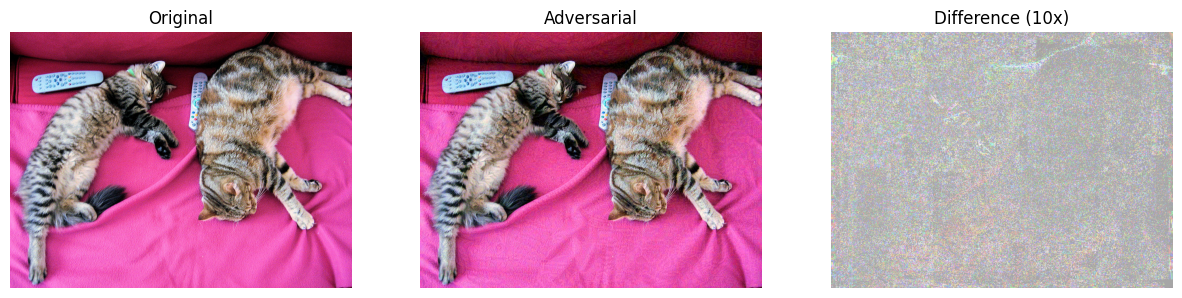

In [6]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original", "Adversarial", "Difference (10x)"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img * 10]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()

# PGD

In [7]:
n_iterations = 100
target_output = torch.tensor([383], dtype=torch.long, device=device) # do the same for 383 - 388
eps = 8. / 255. # perturbation size, set lower than needed for rounding errors
bs = 8 # batch size - not really needed, but stabilizes training and improves convergence & consistency of adversarial examples
alpha = .5 / 255. # step size

x = img_original_tensor.clone()
x.requires_grad = True

loss_func = torch.nn.CrossEntropyLoss()

def forward(x):
    x = differentiable_jpeg(x, random.randint(50, 90))
    x = normalize(x)
    x = random_crop(x)
    x = model(x).logits
    return x

for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    logits = forward(torch.cat([x] * bs, dim=0)) # helps as each forward pass is different, helps stabilize training
    loss = loss_func(logits, torch.cat([target_output] * bs, dim=0))
    
    grad = torch.autograd.grad(loss, x)[0]
    
    x.data = x.data - alpha * torch.sign(grad)
    x.data = torch.clamp(x.data, img_original_tensor - eps, img_original_tensor + eps)

    if iteration % (n_iterations // 10) == 0:
        current_img = tensor_to_img(x)
        diff = np.abs(np.array(current_img).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)
        min_d, mean_d, max_d = diff.min(), diff.mean(), diff.max()

        prediction_idx = torch.argmax(logits).item()
        prediction_prob_mean = torch.nn.functional.softmax(logits, dim=1).mean(0)[prediction_idx].item() * 100

        print(
            f"Iter: {iteration: <4} | Loss: {loss.item(): .4f} | Pred: {prediction_idx} ({prediction_prob_mean:.2f}%) | "
            f"min/mean/max diff: {min_d:.2f}/{mean_d:.2f}/{max_d:.2f}"
        )

Iter: 0    | Loss:  9.8105 | Pred: 281 (48.51%) | min/mean/max diff: 0.00/0.06/1.00
Iter: 10   | Loss:  4.3521 | Pred: 281 (40.86%) | min/mean/max diff: 0.00/0.87/5.00
Iter: 20   | Loss:  5.0837 | Pred: 281 (35.09%) | min/mean/max diff: 0.00/1.42/8.00
Iter: 30   | Loss:  0.6920 | Pred: 383 (50.06%) | min/mean/max diff: 0.00/1.82/9.00
Iter: 40   | Loss:  0.1363 | Pred: 383 (87.25%) | min/mean/max diff: 0.00/2.05/9.00
Iter: 50   | Loss:  0.0625 | Pred: 383 (93.94%) | min/mean/max diff: 0.00/2.22/9.00
Iter: 60   | Loss:  0.0259 | Pred: 383 (97.44%) | min/mean/max diff: 0.00/2.46/9.00
Iter: 70   | Loss:  5.2534 | Pred: 281 (27.16%) | min/mean/max diff: 0.00/2.70/9.00
Iter: 80   | Loss:  0.0133 | Pred: 383 (98.68%) | min/mean/max diff: 0.00/2.89/9.00
Iter: 90   | Loss:  0.0045 | Pred: 383 (99.55%) | min/mean/max diff: 0.00/3.13/9.00


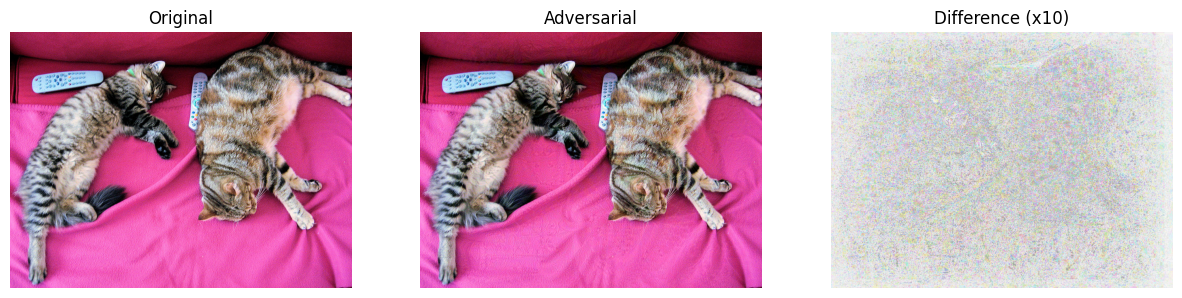

In [8]:
delta_img = np.abs(np.array(tensor_to_img(x)).astype(np.int32) - img_original.astype(np.int32)).astype(np.uint8)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Original", "Adversarial", "Difference (x10)"]
imgs = [img_original, np.array(tensor_to_img(x)), ~delta_img * 10]
for i in range(3):
    ax[i].imshow(imgs[i])
    ax[i].set_title(titles[i])
    ax[i].axis("off")

plt.show()